Import Block: Importing all essential libraries

In [ ]:
import random
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import torch
import cv2  # OpenCV for image processing
import os  # For file and directory operations
from sklearn.svm import SVC  # Support Vector Classification algorithm
from sklearn.ensemble import RandomForestClassifier  # Random Forest algorithm
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer  # For feature scaling and label encoding
from skimage.segmentation import slic  # For superpixel segmentation
from skimage.feature import local_binary_pattern, hog  # For texture and shape features
from skimage import io, color  # For image I/O and color space conversion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm  # For progress bars
from pathlib import Path  # For platform-independent path handling
from typing import Dict, List, Tuple, Set  # Type hints for better code documentation


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


Uploading the dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the zip file in the shared folder
image_path = '/content/drive/My Drive/4/APS360 Group Project/small_dataset_cleaned.zip'

# Destination folder for unzipped files
image_dir = '/content/images'
os.makedirs(image_dir,exist_ok=True)

with zipfile.ZipFile(image_path, 'r') as zip_ref:
    zip_ref.extractall(image_dir)

print(f"Images extracted to: {image_dir}")
# List the contents of the LABELS directory
!ls /content/images/

Mounted at /content/drive
Images extracted to: /content/images
images	labels


Helper Methods:

The read_label_file function reads a label file containing ingredient names, processes each line by stripping whitespace and converting text to lowercase, and returns a list of cleaned ingredient strings. The extract_features function extracts a comprehensive feature vector from an image using superpixel segmentation and various descriptors. It converts the image to the Lab color space and applies the SLIC algorithm to segment it into superpixels. For each superpixel, it extracts color features (average Lab values), texture features (Local Binary Patterns histogram from a grayscale image), and shape features (Histogram of Oriented Gradients). The function combines these features and returns their average as a summarized feature vector.

In [ ]:
def read_label_file(label_path: str) -> List[str]:
    """
    Read and process ingredients from a label file.
    """
    with open(label_path, 'r', encoding='utf-8') as f:
        ingredients = [line.strip().lower() for line in f.readlines()]
    return ingredients

def extract_features(image: np.ndarray) -> np.ndarray:
    """
    Extract features from an image using superpixels and various descriptors.
    """
    # Ensure the image is in the right format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Resize the image to a consistent size
    if image.shape[:2] != (224, 224):
        image = cv2.resize(image, (224, 224))

    # Convert image to Lab color space for better color representation
    lab_img = color.rgb2lab(image)

    # Generate superpixels using SLIC algorithm
    segments = slic(image, n_segments=100, compactness=10)

    features = []

    # Process each superpixel
    for segment_id in np.unique(segments):
        mask = segments == segment_id

        # Extract color features
        segment_lab = lab_img[mask]
        color_features = np.mean(segment_lab, axis=0)

        # Extract texture features using Local Binary Pattern
        gray_img = color.rgb2gray(image)
        lbp = local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        segment_lbp = lbp[mask]
        lbp_hist, _ = np.histogram(segment_lbp, bins=10, density=True)

        # Extract shape features using Histogram of Oriented Gradients
        segment_img = image.copy()
        segment_img[~mask] = 0
        hog_features = hog(
            color.rgb2gray(segment_img),
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            orientations=9
        )

        # Combine all features
        segment_features = np.concatenate([color_features, lbp_hist, hog_features[:10]])
        features.append(segment_features)

    # Return the mean feature vector across all segments
    return np.mean(features, axis=0)

RecipeFoodClassifier:

The RecipeFoodClassifier class is initialized with default parameters, including an SVM with an RBF kernel, a random forest classifier with 100 estimators, a data scaler, a multi-label binarizer, and a batch size. The class also maintains a set of unique ingredients. The process_dataset_structure method processes a dataset containing images and labels. It iterates over recipe folders in an image directory, checking for corresponding label files in a labels folder. If a label file is found, the method reads and updates the set of ingredients, then extracts features from each image using extract_features. It filters out images that don't match the expected shape and handles any errors during processing. If a recipe has valid features, it averages them and appends the result to X, along with the associated ingredients list to y. Finally, it returns the processed features and labels.

In [ ]:
# RecipeFoodClassifier class definition
class RecipeFoodClassifier:
    def __init__(self, batch_size: int = 32):
        # Initialize the SVM and Random Forest classifiers
        self.svm = SVC(kernel='rbf', probability=True)
        self.rf = RandomForestClassifier(n_estimators=100)
        # Initialize the data scaler and MultiLabelBinarizer for label encoding
        self.scaler = StandardScaler()
        self.mlb = MultiLabelBinarizer()
        # Set the batch size for data processing
        self.batch_size = batch_size
        # A set to collect all unique ingredients from the dataset
        self.ingredients_set: Set[str] = set()

    def process_dataset_structure(self, data_path: str, sample_fraction: float = 0.1) -> Tuple[List[np.ndarray], List[List[str]]]:
        """
        Processes a subset of the dataset to avoid processing unnecessary images.
        Only a fraction of the data is processed, as specified by sample_fraction.

        Args:
            data_path (str): Path to the dataset split (e.g., train/validation/test).
            sample_fraction (float): Fraction of the total data to process (default is 0.1).

        Returns:
            Tuple[List[np.ndarray], List[List[str]]]: Processed features and corresponding labels.
        """
        # Convert the data path to a Path object
        data_path = Path(data_path)
        # Define the paths for images and labels
        image_folder = data_path
        labels_folder = data_path.parent.parent / 'labels' / data_path.name
        # Initialize lists to store features and labels
        X = []
        y = []
        # Get a list of all recipe folders in the image folder
        all_recipe_folders = [folder for folder in image_folder.iterdir() if folder.is_dir()]
        # Determine the number of folders to sample based on the sample_fraction
        total_folders = len(all_recipe_folders)
        sample_size = max(1, int(sample_fraction * total_folders))
        sampled_folders = random.sample(all_recipe_folders, sample_size)
        # Loop through the sampled folders to process images and labels
        for recipe_folder in tqdm(sampled_folders):
            key_name = recipe_folder.name
            label_file = labels_folder / f"{key_name}.txt"
            # Skip if the label file does not exist
            if not label_file.exists():
                print(f"Warning: No label file found for {key_name}")
                continue
            # Read ingredients from the label file and update the ingredients set
            ingredients = read_label_file(str(label_file))
            self.ingredients_set.update(ingredients)
            recipe_features = []
            # Loop through all images in the recipe folder
            for img_path in recipe_folder.glob("*.jpg"):
                try:
                    # Read the image
                    image = io.imread(str(img_path))
                    # Convert grayscale images to RGB and resize to 224x224 if necessary
                    if len(image.shape) != 3 or image.shape[2] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                    if image.shape[:2] != (224, 224):
                        image = cv2.resize(image, (224, 224))
                    # Extract features from the image
                    features = extract_features(image)
                    recipe_features.append(features)
                except Exception as e:
                    # Catch and print errors during image processing
                    print(f"Error processing {img_path}: {str(e)}")
                    continue
            # If there are features for the recipe, calculate the average and store it
            if recipe_features:
                avg_features = np.mean(recipe_features, axis=0)
                X.append(avg_features)
                y.append(ingredients)

        return X, y

Dataset Preparation and Training Methods:

The prepare_full_dataset method in the RecipeFoodClassifier class prepares the dataset by iterating over the 'train', 'validation', and 'test' splits in the provided base directory. For each split, it constructs the path and checks if it exists. If the path is valid, it processes the dataset to extract features and labels using process_dataset_structure. The feature arrays are converted to numpy arrays, and the labels are transformed using the MultiLabelBinarizer. The method stores the processed data in a dictionary, with the split name as the key and a tuple of features and labels as the value, then returns this dictionary.

The train method trains the SVM and Random Forest classifiers using the training data from the datasets dictionary. It first scales the training features with StandardScaler and fits both models. If validation data is available, the method scales the validation features and evaluates both models, printing their validation accuracy. This provides feedback on the performance of the models before final testing.

In [ ]:
def prepare_full_dataset(self, base_path: str) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    # Prepare datasets for train, validation, and test splits
    datasets = {}
    random.seed(42)  # Set seed for reproducibility
    # Loop over each data split: train, val, test
    for split in ['train', 'val', 'test']:
        print(f"\nProcessing {split} set...")
        # Define paths for images and labels
        split_image_path = os.path.join(base_path, 'images', 'images', split)
        split_label_path = os.path.join(base_path, 'images', 'labels', split)
        # Check if paths exist; skip if not
        if not os.path.exists(split_image_path) or not os.path.exists(split_label_path):
            print(f"Warning: {split} path does not exist")
            continue
        # Process the dataset structure for this split, using a sample of 10% of the data
        X, y = self.process_dataset_structure(split_image_path, sample_fraction=0.1)
        if not X:
            print(f"Warning: No data processed for {split} set")
            continue
        # Convert features to a numpy array
        X = np.array(X)
        # Encode labels using MultiLabelBinarizer
        if split == 'train':
            y = self.mlb.fit_transform(y)
        else:
            y = self.mlb.transform(y)
        # Store the processed features and labels in the datasets dictionary
        datasets[split] = (X, y)
        print(f"{split} set shape: {X.shape}, Labels shape: {y.shape}")

    return datasets


def train(self, datasets: Dict[str, Tuple[np.ndarray, np.ndarray]]):
    # Ensure that the training data is present in the datasets
    if 'train' not in datasets:
        raise ValueError("Training data not found in datasets")
    # Extract training features and labels
    X_train, y_train = datasets['train']
    # Scale the features using StandardScaler
    X_train_scaled = self.scaler.fit_transform(X_train)
    # Initialize and train the OneVsRest SVM classifier
    self.svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight='balanced'))
    print("Training SVM...")
    self.svm.fit(X_train_scaled, y_train)
    # Train the Random Forest classifier
    print("Training Random Forest...")
    self.rf.fit(X_train_scaled, y_train)
    # Evaluate the models on the training set
    print("\nEvaluating on the training set:")
    self.evaluate_model(X_train_scaled, y_train, "Training")
    # If validation data is available, evaluate on it
    if 'val' in datasets:
        X_val, y_val = datasets['val']
        X_val_scaled = self.scaler.transform(X_val)
        print("\nEvaluating on the validation set:")
        self.evaluate_model(X_val_scaled, y_val, "Validation")
    # If test data is available, evaluate on it
    if 'test' in datasets:
        X_test, y_test = datasets['test']
        X_test_scaled = self.scaler.transform(X_test)
        print("\nEvaluating on the test set:")
        self.evaluate_model(X_test_scaled, y_test, "Test")

def evaluate_model(self, X, y_true, dataset_name: str):
    # Make predictions using SVM and Random Forest
    y_pred_svm = self.svm.predict(X)
    y_pred_rf = self.rf.predict(X)
    # Calculate and print metrics for SVM
    #accuracy_svm = accuracy_score(y_true, y_pred_svm)
    precision_svm = precision_score(y_true, y_pred_svm, average='micro',zero_division=1)  # Added precision metric
    recall_svm = recall_score(y_true, y_pred_svm, average='micro',zero_division=1)        # Added recall metric
    f1_svm = f1_score(y_true, y_pred_svm, average='micro',zero_division=1)                # Added F1 score metric
    # Calculate and print metrics for Random Forest
    #accuracy_rf = accuracy_score(y_true, y_pred_rf)
    precision_rf = precision_score(y_true, y_pred_rf, average='micro',zero_division=1)    # Added precision metric
    recall_rf = recall_score(y_true, y_pred_rf, average='micro',zero_division=1)          # Added recall metric
    f1_rf = f1_score(y_true, y_pred_rf, average='micro',zero_division=1)                  # Added F1 score metric
    # Print metrics for SVM
    print(f"\n{dataset_name} Metrics for SVM:")
    #print(f"Accuracy: {accuracy_svm:.4f}, Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}, F1 Score: {f1_svm:.4f}")
    print(f"Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}, F1 Score: {f1_svm:.4f}")
    print("\nSVM Classification Report:")
    print(classification_report(y_true, y_pred_svm, target_names=self.mlb.classes_))
    # Print metrics for Random Forest
    print(f"\n{dataset_name} Metrics for Random Forest:")
    #print(f"Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f}")
    print(f"Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f}")
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_true, y_pred_rf, target_names=self.mlb.classes_))

    # Plot and compare metrics
    self.plot_metrics([precision_svm, recall_svm, f1_svm], [precision_rf, recall_rf, f1_rf], dataset_name)

def plot_metrics(self, svm_metrics, rf_metrics, dataset_name: str):
    # Define metric labels and x-axis positions
    #labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    labels = ['Precision', 'Recall', 'F1 Score']
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars in the bar chart

    # Create a bar chart comparing SVM and Random Forest metrics
    plt.figure(figsize=(10, 5))
    plt.bar(x - width / 2, svm_metrics, width, label='SVM', color='blue')  # Bar for SVM metrics
    plt.bar(x + width / 2, rf_metrics, width, label='Random Forest', color='green')  # Bar for RF metrics
    plt.xlabel('Metrics')  # Label for the x-axis
    plt.ylabel('Scores')   # Label for the y-axis
    plt.title(f'{dataset_name} Set Metrics Comparison')  # Chart title
    plt.xticks(x, labels)  # Set x-axis labels
    plt.legend()  # Show legend
    plt.show()    # Display the plot


# Add these methods to the RecipeFoodClassifier class
RecipeFoodClassifier.prepare_full_dataset = prepare_full_dataset
RecipeFoodClassifier.train = train
RecipeFoodClassifier.evaluate_model = evaluate_model
RecipeFoodClassifier.plot_metrics = plot_metrics

Prediction Method:
The predict_single_image method in the RecipeFoodClassifier class predicts ingredients for a given image. It reads the image from the specified image_path and resizes it to 224x224 pixels if necessary. The method then extracts features from the image and scales them using the trained StandardScaler. It uses both the SVM and Random Forest classifiers to compute prediction probabilities and averages them to generate a final set of probabilities. The method identifies the top 5 most likely ingredients, sorts them by confidence in descending order, and constructs a list of dictionaries containing the ingredient names and their respective confidence scores. Finally, it returns these predictions in a dictionary format.

In [ ]:
def predict_single_image(self, image_path: str) -> Dict:
    image = io.imread(image_path)
    if image.shape != (224, 224, 3):
        image = cv2.resize(image, (224, 224))
    features = extract_features(image)
    features_scaled = self.scaler.transform(features.reshape(1, -1))
    svm_pred = self.svm.predict_proba(features_scaled)
    rf_pred = self.rf.predict_proba(features_scaled)
    final_pred = (svm_pred + rf_pred) / 2
    top_indices = np.argsort(final_pred[0])[-5:][::-1]
    predictions = []

    for idx in top_indices:
        ingredient = self.mlb.classes_[idx]
        confidence = final_pred[0][idx]
        predictions.append({
            'ingredient': ingredient,
            'confidence': float(confidence)
        })

    return {'predictions': predictions}

# Add this method to the RecipeFoodClassifier class
RecipeFoodClassifier.predict_single_image = predict_single_image

Usage:


Processing train set...


  0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 35/35 [14:26<00:00, 24.75s/it]


train set shape: (35, 23), Labels shape: (35, 97)

Processing val set...


100%|██████████| 7/7 [04:14<00:00, 36.42s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['balsamic vinegar', 'barbecue sauce', 'cream', 'deglet noor dates', 'fresh dill weed', 'fresh parsley', 'link/patty pork sausage', 'neufchatel cheese', 'pistachio nuts', 'radishes', 'sun-dried tomatoes', 'sweet cherries', 'worcestershire sauce'] will be ignored
  warnings.warn(


val set shape: (7, 23), Labels shape: (7, 97)

Processing test set...


100%|██████████| 7/7 [04:46<00:00, 40.87s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['bitter-sweet dark chocolate chips', 'broccoli', 'carbonated beverages', 'italian seasoned breadcrumbs delallo', 'raspberries', 'spinach', 'vanilla ice cream', 'whipped cream'] will be ignored
  warnings.warn(


test set shape: (7, 23), Labels shape: (7, 97)
Training SVM...
Training Random Forest...

Evaluating on the training set:

Training Metrics for SVM:
Precision: 0.9130, Recall: 0.9859, F1 Score: 0.9481

SVM Classification Report:
                                   precision    recall  f1-score   support

                          almonds       1.00      1.00      1.00         1
                           apples       1.00      1.00      1.00         1
       apricot jams and preserves       1.00      1.00      1.00         1
                    baking powder       1.00      1.00      1.00         2
                      baking soda       1.00      1.00      1.00         1
                          bananas       1.00      1.00      1.00         1
                            basil       1.00      1.00      1.00         1
                      blueberries       1.00      1.00      1.00         1
                    bottled water       1.00      0.90      0.95        10
               bread

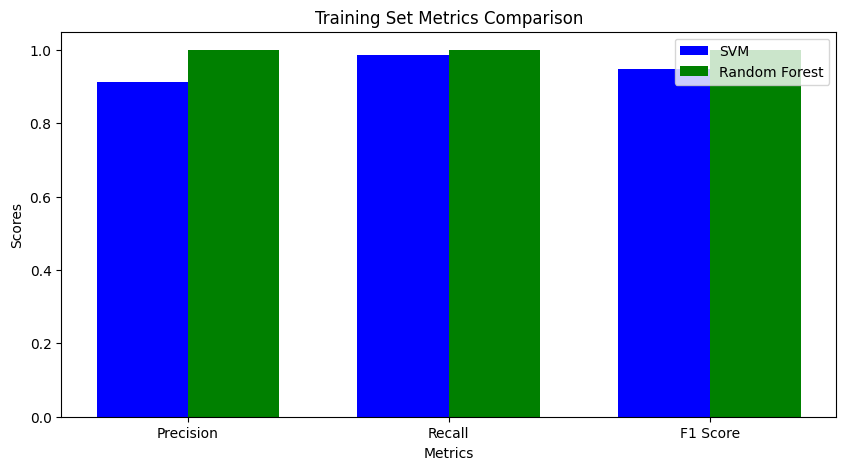


Evaluating on the validation set:

Validation Metrics for SVM:
Precision: 0.2368, Recall: 0.3913, F1 Score: 0.2951

SVM Classification Report:
                                   precision    recall  f1-score   support

                          almonds       0.00      0.00      0.00         0
                           apples       0.00      0.00      0.00         0
       apricot jams and preserves       1.00      1.00      1.00         1
                    baking powder       0.00      0.00      0.00         0
                      baking soda       0.00      0.00      0.00         0
                          bananas       0.00      0.00      0.00         0
                            basil       0.00      0.00      0.00         2
                      blueberries       0.00      0.00      0.00         0
                    bottled water       0.50      1.00      0.67         1
               bread wheat flours       0.00      0.00      0.00         0
        broiler or fryers chic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

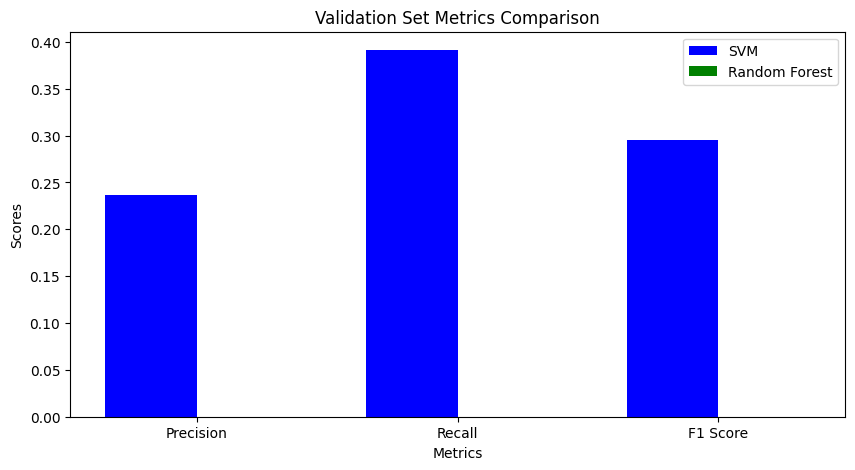


Evaluating on the test set:

Test Metrics for SVM:
Precision: 0.0938, Recall: 0.1200, F1 Score: 0.1053

SVM Classification Report:
                                   precision    recall  f1-score   support

                          almonds       0.00      0.00      0.00         0
                           apples       0.00      0.00      0.00         0
       apricot jams and preserves       0.00      0.00      0.00         0
                    baking powder       0.00      0.00      0.00         0
                      baking soda       0.00      0.00      0.00         0
                          bananas       0.00      0.00      0.00         0
                            basil       0.00      0.00      0.00         0
                      blueberries       0.00      0.00      0.00         0
                    bottled water       0.50      0.33      0.40         3
               bread wheat flours       0.00      0.00      0.00         0
        broiler or fryers chicken       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

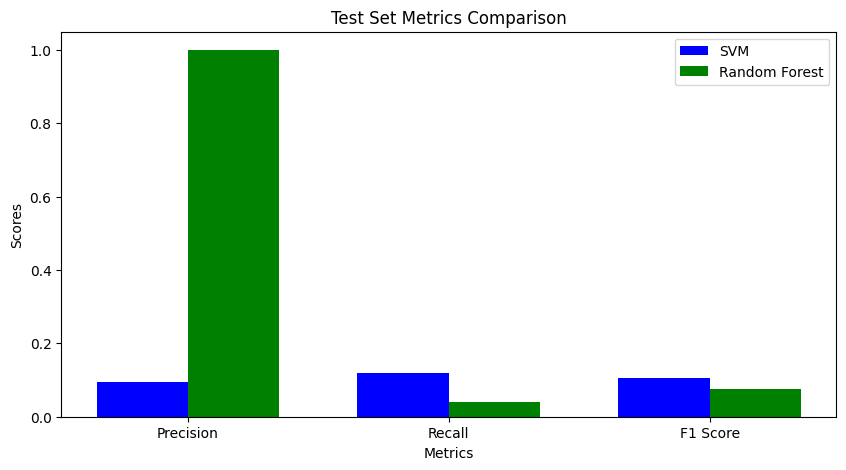

In [ ]:
# Initialize the classifier
classifier = RecipeFoodClassifier()

# Set your dataset path
base_path = '/content'  # Ensure this path points to the correct location where you extracted your dataset

# Prepare datasets
datasets = classifier.prepare_full_dataset(base_path)

# Train the models and display the training performance report
classifier.train(datasets)

In [ ]:
!jupyter nbconvert --to html "FoodClassifier_RandomForest.ipynb"

[NbConvertApp] Converting notebook FoodClassifier_RandomForest.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][13]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': '\nProcessing train set...\n'}
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 560308 bytes to FoodClassifier_RandomForest.html
